# 03.Keras Subclassing of Tensorflow 2.1

__author__ = "Trung Phong Le"<br>
__email__ = "letrungphong95@gmail.com"<br>
__startDate__ = "15/02/2020"<br>
__version__ = "0.0.1"<br>
__status__ = "Being a Magical Dev"<br>
__maintainer__ = "Trung Phong Le"

In [1]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import os 
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.1.0


## 3.1 Loading MNIST dataset

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Reshape and normalize 
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255.0
# Split training data to train and validation data 
x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]
print("=======> Number of training images: ", x_train.shape[0], ".Shape: ", x_train.shape)
print("=======> Number of validation images: ", x_val.shape[0], ".Shape: ", x_val.shape)
print("=======> Number of testing images: ", x_test.shape[0], ".Shape: ", x_test.shape)

=======> Number of training images:  50000 .Shape:  (50000, 28, 28, 1)
=======> Number of validation images:  10000 .Shape:  (10000, 28, 28, 1)
=======> Number of testing images:  10000 .Shape:  (10000, 28, 28, 1)


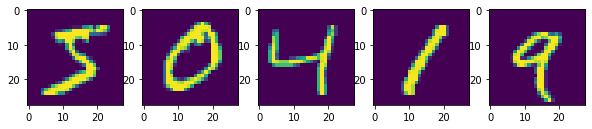

In [3]:
# Visualize data
plt.figure(figsize=(10, 10))
for i, image in enumerate(x_train[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(image.reshape(28, 28))

## 3.2 Building Keras Subclassing model

In [4]:
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPool2D

In [5]:
class SimpleModel(Model):
    def __init__(self, num_classes):
        # call the parent constructor
        super(SimpleModel, self).__init__()
        
        # Initialize the layer
        self.conv1 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu')
        self.pool1 = MaxPool2D(pool_size=(2,2), padding='valid')
        self.flatten = Flatten()
        self.dense = Dense(units=128, activation='relu')
        self.out = Dense(units=num_classes, activation='softmax')
    
    def call(self, inputs):
        # Build the model
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.out(x)
        return x

In [6]:
model = SimpleModel(10)
model.build((None, 28, 28, 1))
model.summary()

Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  692352    
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


## 3.3 Training model

In [7]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
# Hyperparameters 
LR = 1e-2
BATCH_SIZE = 128
NUM_EPOCHS = 2

In [8]:
# Initialize the optimizer and compile the model
opt = SGD(lr=LR, momentum=0.9, decay=LR/NUM_EPOCHS)
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=opt,
             metrics=["accuracy"])
# Save checkpoints 
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
filepath = "checkpoints/CNN-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=0,
                             save_weight_only=False, save_best_only=False, mode='max')
# Train model 
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, 
                    validation_data = (x_val, y_val), verbose=1, callbacks=[checkpoint])

# Save final model weights
model.save_weights('checkpoints/final_model.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 16s 314us/sample - loss: 0.4531 - accuracy: 0.8682 - val_loss: 0.2493 - val_accuracy: 0.9270
Epoch 2/2
50000/50000 [==============================] - 17s 345us/sample - loss: 0.2256 - accuracy: 0.9328 - val_loss: 0.1873 - val_accuracy: 0.9467


In [9]:
# Test on testing data
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

10000/10000 [==============================] - 2s 222us/sample - loss: 0.1918 - accuracy: 0.9445
Test loss:  0.19183600734323264
Test accuracy:  0.9445


## 3.4 Predicting model

In [10]:
result = model.predict(x_test)
print("Result shape: ", result.shape)

Result shape:  (10000, 10)


True label:  1
Predicted label:  1


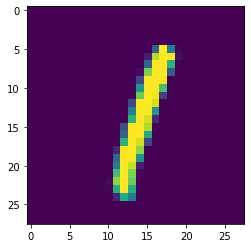

In [11]:
idx = 5
print("True label: ", y_test[idx])
print("Predicted label: ", np.argmax(result[idx]))
plt.imshow(np.squeeze(x_test[idx]))
plt.show()

## 3.5 Loading saved model

In [12]:
new_model = SimpleModel(10)
new_model.build((None, 28, 28, 1))
new_model.summary()
# load weights into new model
new_model.load_weights('checkpoints/final_model.h5')
print("Loaded model from disk")
new_model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

Model: "simple_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            multiple                  320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  692352    
_________________________________________________________________
dense_3 (Dense)              multiple                  1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________
Loaded model from disk


In [13]:
# Test on testing data
test_loss, test_acc = new_model.evaluate(x_test, y_test)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

10000/10000 [==============================] - 2s 172us/sample - loss: 0.1918 - accuracy: 0.9445
Test loss:  0.19183600734323264
Test accuracy:  0.9445
